# Intro to Ray Tune

This notebook will walk you through the basics of hyperparameter tuning with Ray Tune.

<div class="alert alert-block alert-info">
<p> Here is the roadmap for this notebook:</p>
<ul>
    <li> <b>Part 1:</b> Loading the data </li>
    <li> <b>Part 2:</b> Starting out with vanilla PyTorch </li>
    <li> <b>Part 3:</b> Hyperparameter tuning with Ray Tune </li>
    <li> <b>Part 4:</b> Ray Tune in production </li>
</ul>
</div>


## Imports

In [2]:
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

import ray
from ray import tune, train
from ray.tune.search import optuna

## 1. Loading the data

Our Dataset is the MNIST dataset

The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9).

**Dataset details:**
- Training set: 60,000 images
- Test set: 10,000 images
- Image size: 28x28 pixels
- Number of classes: 10 (digits 0-9)

**Data format:**
Each image is represented as a 2D array of pixel values, where each pixel is a grayscale intensity between 0 (black) and 255 (white).



In [3]:
def build_data_loader(batch_size: int) -> torch.utils.data.DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)
    data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

Let's visualize a batch

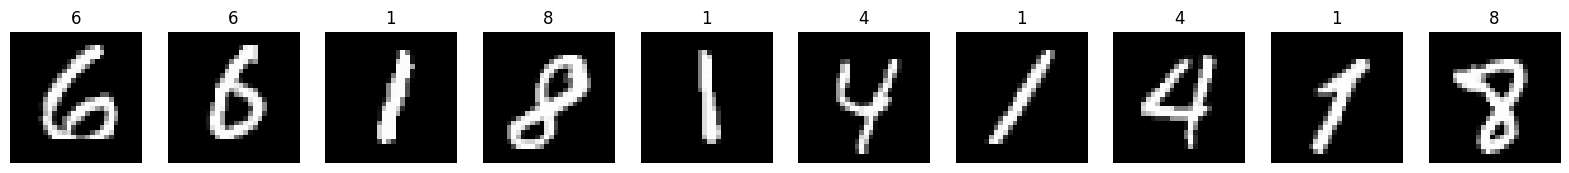

In [5]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

data_loader = build_data_loader(batch_size=10)

for (images, labels) in data_loader:
    
    for i, (image, label) in enumerate(zip(images, labels)):
        axs[i].imshow(image.squeeze(), cmap="gray")
        axs[i].set_title(label.item())
        axs[i].axis("off")
    break

## 2. Starting out with vanilla PyTorch

Here is a high level overview of the model training process:

- **Objective**: Classify handwritten digits (0-9)
- **Model**: Simple Neural Network using PyTorch
- **Evaluation Metric**: Accuracy
- **Dataset**: MNIST

We'll start with a basic PyTorch implementation to establish a baseline before moving on to more advanced techniques. This will give us a good foundation for understanding the benefits of hyperparameter tuning and distributed training in later sections.

In [6]:
def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, lr: float = 1e-5):
    criterion = CrossEntropyLoss()

    model = resnet18()
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to("cuda")
    data_loader = build_data_loader(batch_size)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Report the metrics
        print(f"Epoch {epoch}, Loss: {loss}")

We fit the model by submitting it onto a GPU node using Ray Core

In [7]:
train_loop_torch(num_epochs=2)

Epoch 0, Loss: 0.34998491406440735
Epoch 1, Loss: 0.07872242480516434


**Can we do any better ?** let's see if we can tune the hyperparameters of our model to get a better loss.

But hyperparameter tuning is a computationally expensive task, and it will take a long time to run sequentially.

[Ray Tune](https://docs.ray.io/en/master/tune/) is a distributed hyperparameter tuning library that can help us speed up the process!

## 3. Hyperparameter tuning with Ray Tune

### Intro to Ray Tune

<img src="https://docs.ray.io/en/master/_images/tune_overview.png" width="250">

Tune is a Python library for experiment execution and hyperparameter tuning at any scale.

Let's take a look at a very simple example of how to use Ray Tune to tune the hyperparameters of our XGBoost model.

### Getting started

We start by defining our training function

In [8]:
def my_simple_model(distance: np.ndarray, a: float) -> np.ndarray:
    return distance * a

# Step 1: Define the training function
def train_my_simple_model(config: dict[str, Any]) -> None: # Expected function signature for Ray Tune
    distances = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    total_amts = distances * 10
    
    a = config["a"]
    predictions = my_simple_model(distances, a)
    rmse = np.sqrt(np.mean((total_amts - predictions) ** 2))

    train.report({"rmse": rmse}) # This is how we report the metric to Ray Tune

<div class="alert alert-block alert-warning">
<b>Note:</b> how the training function needs to accept a config argument. This is because Ray Tune will pass the hyperparameters to the training function as a dictionary.
</div>

Next, we define and run the hyperparameter tuning job by following these steps:

1. Create a `Tuner` object (in our case named `tuner`)
2. Call `tuner.fit`

In [9]:
# Step 2: Set up the Tuner
tuner = tune.Tuner(
    trainable=train_my_simple_model,  # Training function or class to be tuned
    param_space={
        "a": tune.randint(0, 20),  # Hyperparameter: a
    },
    tune_config=tune.TuneConfig(
        metric="rmse",  # Metric to optimize (minimize)
        mode="min",     # Minimize the metric
        num_samples=5,  # Number of samples to try
    ),
)

# Step 3: Run the Tuner and get the results
results = tuner.fit()

(train_my_simple_model pid=3500357) /data/archive/ray/course/intro2ray/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_my_simple_model pid=3500357)   _log_deprecation_warning(
2025-04-15 17:49:10,469	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/map/ray_results/train_my_simple_model_2025-04-15_17-49-03' in 0.0153s.
2025-04-15 17:49:10,474	INFO tune.py:1041 -- Total run time: 2.84 seconds (2.78 seconds for the tuning loop).
(train_my_simple_model pid=3500354) /data/archive/ray/course/intro2ray/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a fun

In [10]:
# Step 4: Get the best result
best_result = results.get_best_result()
best_result

Result(
  metrics={'rmse': np.float64(0.3316624790355401)},
  path='/home/map/ray_results/train_my_simple_model_2025-04-15_17-49-03/train_my_simple_model_74ff3_00003_3_a=11_2025-04-15_17-49-07',
  filesystem='local',
  checkpoint=None
)

In [11]:
best_result.config

{'a': 11}

So let's recap what actually happened here ?

```python
tuner = tune.Tuner(
    trainable=train_my_simple_model,  # Training function or class to be tuned
    param_space={
        "a": tune.randint(0, 20),  # Hyperparameter: a
    },
    tune_config=tune.TuneConfig(
        metric="rmse",  # Metric to optimize (minimize)
        mode="min",     # Minimize the metric
        num_samples=5,  # Number of samples to try
    ),
)

results = tuner.fit()
```

A Tuner accepts:
- A training function or class which is specified by `trainable`
- A search space which is specified by `param_space`
- A metric to optimize which is specified by `metric` and the direction of optimization `mode`
- `num_samples` which correlates to the number of trials to run

`tuner.fit` then runs multiple trials in parallel, each with a different set of hyperparameters, and returns the best set of hyperparameters found.


### Diving deeper into Ray Tune concepts

You might be wondering:
- How does the tuner allocate resources to trials?
- How does it decide how to tune - i.e. which trials to run next?
    - e.g. A random search, or a more sophisticated search algorithm like a bayesian optimization algorithm.
- How does it decide when to stop - i.e. whether to kill a trial early?
    - e.g. If a trial is performing poorly compared to other trials, it perhaps makes sense to stop it early (successive halving, hyperband)

It turns out that by default: 
- Each trial will run in a separate process and consume 1 CPU core.
- Ray Tune uses a search algorithm to decide which trials to run next.
- Ray Tune uses a scheduler to decide if/when to stop trials, or to prioritize certain trials over others.

Here is the same code with the default settings for Ray Tune *explicitly* specified.

In [ ]:
tuner = tune.Tuner(
    # This is how to specify resources for your trainable function
    trainable=tune.with_resources(train_my_simple_model, {"cpu": 1}),
    param_space={"a": tune.randint(0, 20)},
    tune_config=tune.TuneConfig(
        mode="min",
        metric="rmse",
        num_samples=5, 
        # This search algorithm is a basic variation (i.e random/grid search) based on parameter space
        search_alg=tune.search.BasicVariantGenerator(), 
        # This scheduler is very simple: no early stopping, just run all trials in submission order
        scheduler=tune.schedulers.FIFOScheduler(), 
    ),
)
results = tuner.fit()

Below is a diagram showing the relationship between the different Ray Tune components we have discussed.

<img src="https://docs.ray.io/en/latest/_images/tune_flow.png" width="800" />


To learn more about the key tune concepts, you can visit the [Ray Tune documentation here](https://docs.ray.io/en/master/tune/key-concepts.html).

Here is the same experiment table annotated 

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/attentive-ray-101/experiment_table_annotated.png" width="800" />




#### Exercise

<div class="alert alert-block alert-info">
    
__Lab activity: Finetune a linear regression model.__
    

Given the below code to train a linear regression model from scratch: 

```python
def train_linear_model(lr: float, epochs: int) -> None:
    x = np.array([0, 1, 2, 3, 4])
    y = x * 2
    w = 0
    for _ in range(epochs):
        loss = np.sqrt(np.mean((w * x - y) ** 2))
        dl_dw = np.mean(2 * x * (w * x - y)) 
        w -= lr * dl_dw
        print({"rmse": loss})

# Hint: Step 1 update the function signature

# Hint: Step 2 Create the tuner object
tuner = tune.Tuner(...)

# Hint: Step 3: Run the tuner
results = tuner.fit()
```

Use Ray Tune to tune the hyperparameters `lr` and `epochs`. 

Perform a search using the optuna.OptunaSearch search algorithm with 5 samples over the following ranges:
- `lr`: loguniform(1e-4, 1e-1)
- `epochs`: randint(1, 100)

</div>


In [ ]:
# Write your code here


<div class="alert alert-block alert-info">
<details>
<summary>Click here to view the solution</summary>

```python
def train_linear_model(config) -> None:
    epochs = config["epochs"]
    lr = config["lr"]
    x = np.array([0, 1, 2, 3, 4])
    y = x * 2
    w = 0
    for _ in range(epochs):
        loss = np.sqrt(np.mean((w * x - y) ** 2))
        dl_dw = np.mean(2 * x * (w * x - y)) 
        w -= lr * dl_dw
        train.report({"rmse": loss})

tuner = tune.Tuner(
    trainable=train_linear_model,  # Training function or class to be tuned
    param_space={
        "lr": tune.loguniform(1e-4, 1e-1),  # Hyperparameter: learning rate
        "epochs": tune.randint(1, 100),  # Hyperparameter: number of epochs
    },
    tune_config=tune.TuneConfig(
        metric="rmse",  # Metric to optimize (minimize)
        mode="min",     # Minimize the metric
        num_samples=5,  # Number of samples to try
        search_alg=optuna.OptunaSearch(), # Use Optuna for hyperparameter search
    ),
)

results = tuner.fit()
```

</details>
</div>

### Hyperparameter tune the PyTorch model using Ray Tune

The first step is to move in all the PyTorch code into a function that we can pass to the `trainable` argument of the `tune.run` function.

In [12]:
def train_pytorch(config): # we change the function so it accepts a config dictionary
    criterion = CrossEntropyLoss()

    model = resnet18()
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to("cuda")

    optimizer = Adam(model.parameters(), lr=config["lr"])
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)
    data_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, drop_last=True)

    for epoch in range(config["num_epochs"]):
        for images, labels in data_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Report the metrics using train.report instead of print
        train.report({"loss": loss.item()})

The second and third steps are the same as before. We define the tuner and run it by calling the fit method.

In [ ]:
tuner = tune.Tuner(
    trainable=tune.with_resources(train_pytorch, {"gpu": 1}), # we will dedicate 1 GPU to each trial
    param_space={
        "num_epochs": 1,
        "batch_size": 128,
        "lr": tune.loguniform(1e-4, 1e-1),
    },
    tune_config=tune.TuneConfig(
        mode="min",
        metric="loss",
        num_samples=2,
        search_alg=tune.search.BasicVariantGenerator(),
        scheduler=tune.schedulers.FIFOScheduler(),
    ),
)

results = tuner.fit()

Finally, we can get the best result and its configuration:

In [ ]:
best_result = results.get_best_result()
best_result.config

## 4. Ray Tune in Production

Here are some use-cases of using Ray Train in production:
1. The Uber internal autotune service uses Ray Tune. See the uber blog post [here](https://www.uber.com/blog/from-predictive-to-generative-ai/).
2. How Spotify makes use of Ray Tune for hyperparameter tuning. See the spotify blog post [here](https://engineering.atspotify.com/2023/02/unleashing-ml-innovation-at-spotify-with-ray/)